# **CMPINF 2221: Applied Bayesian Data Analysis**

**Question 1: Bayesian Decision Making in Election Strategy**

A political strategist is trying to decide whether to allocate campaign resources to a particular state in an upcoming election. The goal is to determine whether the state is likely to vote for their candidate. There are two possible actions: allocate resources to the state (Action A) or not allocate resources (Action B). *If Action A is taken*, there are two possible outcomes:

- If the state votes for their candidate (true state of nature), the strategist incurs a loss of 5 units due to resource expenditure.

- If the state does not vote for their candidate, the strategist incurs a loss of 50 units due to wasted resources.

*If Action B is taken* (no resources allocated), there are two possible outcomes:

- If the state votes for their candidate, the loss is 20 units due to missed opportunity.

- If the state does not vote for their candidate, the loss is 0 units (no resources were allocated).

The strategist has a prior belief about the likelihood that the state will vote for their candidate, modeled as a Beta distribution: P(vote for candidate)∼Beta(3,2), reflecting moderate optimism based on past data.

Plot the prior distribution of P(vote for candidate). How does the prior reflect the strategist's belief about the likelihood of winning the state? (**Q1**).

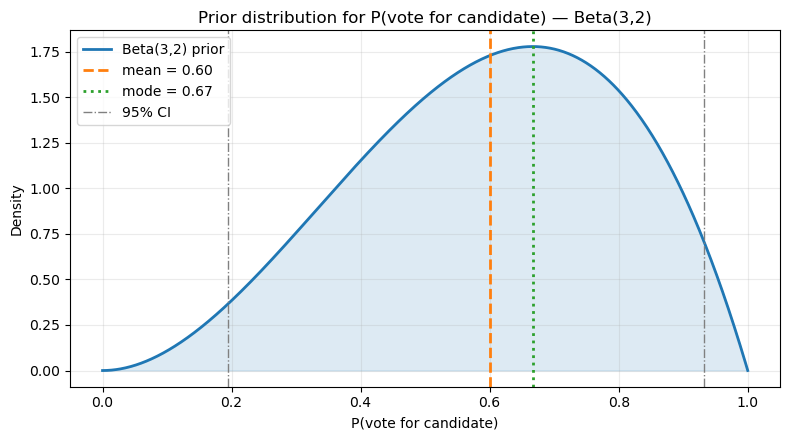

Mean = 0.600
Mode = 0.667
95% credible interval ≈ [0.194, 0.932]


In [2]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
from math import factorial
import scipy.integrate as integrate


# your code here
# beta prior parameters for P[vote for candidate]
alpha = 3
beta_param = 2

# x grid on [0,1]
x = np.linspace(0, 1, 1000)

# pdf of Beta(3,2)
y = beta.pdf(x, a=alpha, b=beta_param)

# summary stats
mean = alpha / (alpha + beta_param)
mode = (alpha - 1) / (alpha + beta_param - 2) if alpha > 1 and beta_param > 1 else None
ci_lower, ci_upper = beta.ppf([0.025, 0.975], a=alpha, b=beta_param)


# plot the Beta prior for P[vote for candidate]
plt.figure(figsize=(8, 4.5))
plt.plot(x, y, lw=2, label=r'Beta(3,2) prior')
plt.fill_between(x, 0, y, color='C0', alpha=0.15)
plt.axvline(mean, color='C1', linestyle='--', lw=2, label=f'mean = {mean:.2f}')
if mode is not None:
    plt.axvline(mode, color='C2', linestyle=':', lw=2, label=f'mode = {mode:.2f}')
plt.axvline(ci_lower, color='gray', linestyle='-.', lw=1)
plt.axvline(ci_upper, color='gray', linestyle='-.', lw=1, label='95% CI')
plt.title('Prior distribution for P(vote for candidate) — Beta(3,2)')
plt.xlabel('P(vote for candidate)')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# Print summary
print(f"Mean = {mean:.3f}")
if mode is not None:
    print(f"Mode = {mode:.3f}")
print(f"95% credible interval ≈ [{ci_lower:.3f}, {ci_upper:.3f}]")

After receiving new polling data that suggests a 60% probability of the state voting for the candidate, update the prior using Bayes' Theorem to obtain the posterior distribution of P(vote for candidate).

In [4]:
# prior
a,b = 3,2
rv = beta(a, b)

prior = lambda x: rv.pdf(x)

# likelihood based on polling data
# the poll suggests 60% support for the candidate

p_hat = 0.60 # reported poll proportion
n = 50 # sample size for poll
k = int(round(p_hat * n)) # this is the number of 'successes'

def likelihood(x):
    # supports both scalar and numpy array x
    return x**k * (1.0 - x)**(n - k)

# define the total probability and find the normalization constant (evidence)
evidence, _ = integrate.quad(lambda t: prior(t) * likelihood(t), 0.0, 1.0)
if evidence <= 0:
    raise ValueError("Computed evidence is non-positive. Check inputs.")

# define the posterior through Bayes
# post supports numpy arrays because prior and likelihood accept arrays
post = lambda x: prior(x) * likelihood(x) / evidence

# create p_x for plotting (the user asked to use p_x)
p_x = np.linspace(0.0, 1.0, 1000)



<function __main__.<lambda>(x)>

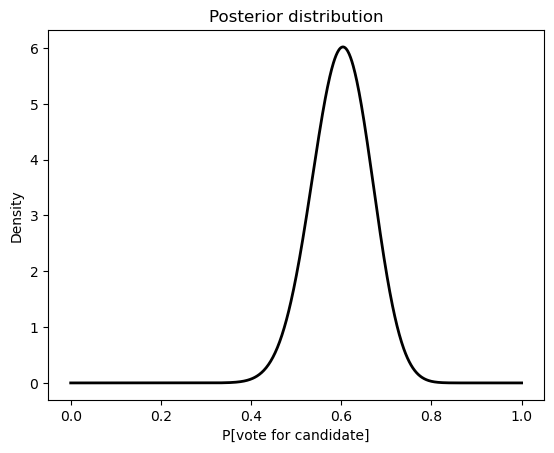

In [4]:
fig, ax = plt.subplots(1, 1)
plt.xlabel("P[vote for candidate]")
plt.ylabel("Density")
plt.title("Posterior distribution")
ax.plot(p_x, post(p_x), 'k-', lw=2)
plt.show()

Create a function `expected_loss(loss_matrix, posterior)` that takes as input the posterior distribution and a 2x2 cost matrix, and returns the expected loss for each of the 2 possible actions. Which action minimizes the expected loss? (**Q2**).

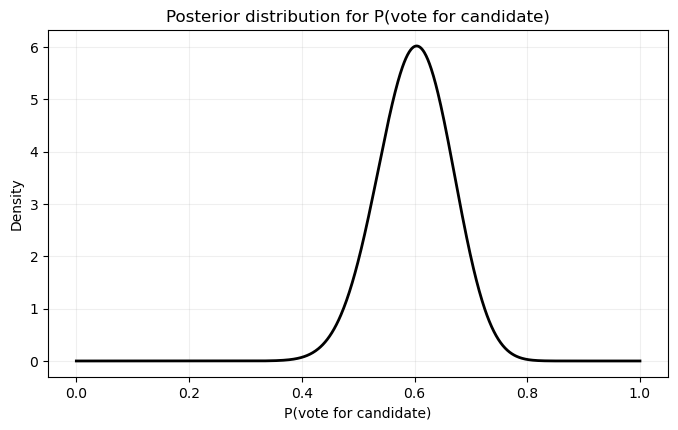

Expected losses:
  Action A (order comprehensive testing): 23.000000
  Action B (skip additional testing):     12.000000
Action minimizing expected loss: Skip additional testing (B)


In [6]:
# 1) Plot the posterior (uses p_x and post already defined)
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
# ensure post works with numpy arrays
try:
    y = post(p_x)
except Exception:
    y = np.vectorize(post)(p_x)
ax.plot(p_x, y, 'k-', lw=2)
ax.set_xlabel("P(vote for candidate)")
ax.set_ylabel("Density")
ax.set_title("Posterior distribution for P(vote for candidate)")
ax.grid(alpha=0.2)
plt.show()

# define the loss matrix: each row corresponds to an option and the columns correspond to the 2 outcomes
# loss/cost matrix
L = [[5,50], # action a: allocate resources
     [20, 0]] # action b: do not allocate the resources


def expected_loss(loss_matrix, posterior):
     # Ensure posterior can be evaluated on scalars for integrate.quad
    def posterior_scalar(p):
        try:
            return float(posterior(p))
        except Exception:
            return float(np.vectorize(posterior)(np.array([p])))

    expected = []
    for row in loss_matrix:
        L_win = float(row[0]) 
        L_lose = float(row[1])
        # integrand: expected loss at probability p: L_diabetes * p + L_no_diabetes * (1 - p)
        integrand = lambda p: (L_win * p + L_lose * (1.0 - p)) * posterior_scalar(p)
        val, err = integrate.quad(integrand, 0.0, 1.0, epsabs=1e-9, epsrel=1e-9)
        expected.append(val)
    return expected

# 3) Compute expected losses and report best action
expected_losses = expected_loss(L, post)
print("Expected losses:")
print(f"  Action A (order comprehensive testing): {expected_losses[0]:.6f}")
print(f"  Action B (skip additional testing):     {expected_losses[1]:.6f}")

best_action_idx = int(np.argmin(expected_losses))
action_names = ["Order comprehensive testing (A)", "Skip additional testing (B)"]
print(f"Action minimizing expected loss: {action_names[best_action_idx]}")

In [ ]:
## TEST 1 CELL

**Question 2: Sequential Stock Price Prediction**

In this part you will be tasked with estimating the posterior distribution of Tesla’s stock price S(t), given noise observations, i.e., the daily closing prices of a stock, up to time t, y(t). We will consider the logarithmic random walk model for the stock price (a common model used in financial applications).  In this model we have x(t) = log(S(t)), with x(t) = x(t-1) + μ + ε(t), where the error term follows a normal distribution with 0 mean and a standard deviation of σ that represents the volatility of the stock (variance of log-return) and μ is the average log return of the stock.

What we observe at the end of each day is y(t), i.e., a noisy version of S(t) essentially. So the observation y(t) can be expressed as y(t) = exp(x(t)) * η(t), where η(t) follows a lognormal distribution with 0 mean and a standard deviation of τ. Equivalently, log(y(t)) = x(t) + v(t), where v(t) now follows a normal distribution with 0 mean and a standard deviation of τ.

Using SIS your goal is to obtain a (sequential) estimate of p(x(t) | y(1:t)). You are provided with most of the implementation code for SIS below. The only part missing is the re-weighting of the particles. You will be tasked with creating a function `systematic_resampling(particles, weights, N)` that will take as input the current N particles and their weights and will return the new resampled particles.

First, run SIS without resampling and plot at the same graph the observed prices y(t) and the estimated S(t), i.e., the particle mean. (**Q3**)

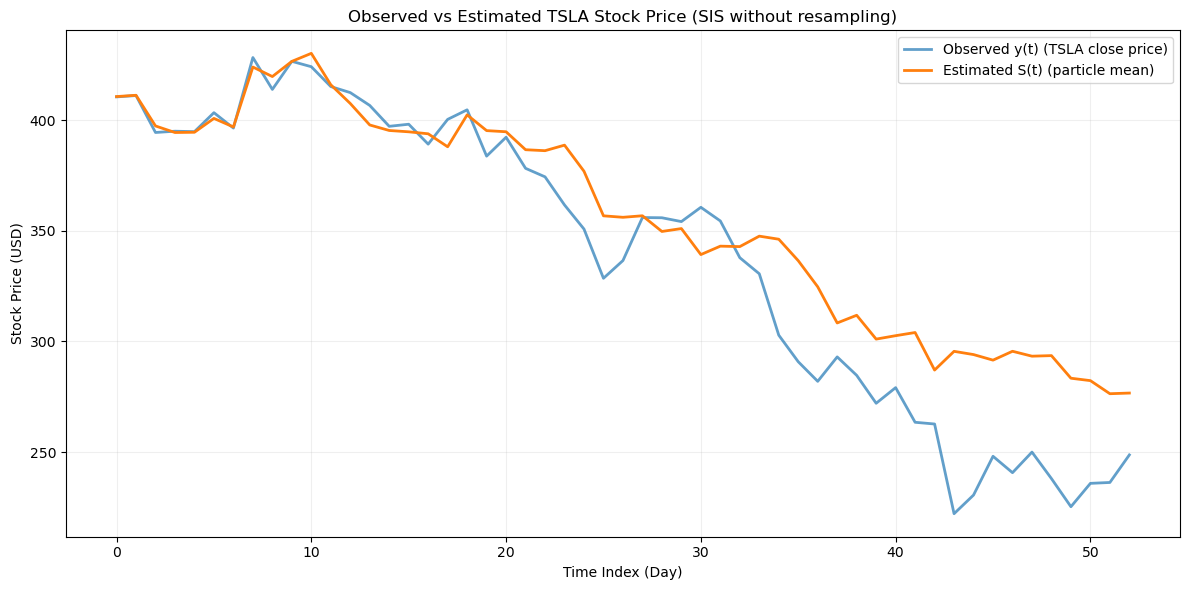

In [9]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

def systematic_resampling(particles, weights, N):
    positions = (np.random.rand() + np.arange(N)) / N
    cumulative = np.cumsum(weights)
    indices = np.searchsorted(cumulative, positions)
    indices = np.clip(indices, 0, N-1) 
    return particles[indices, :]
    
# SIS with Resampling (Particle Filter)
def sequential_importance_sampling(stock_prices, N=1000, mu=0.001, sigma=0.02, tau=0.01, resampling = False):
    T = len(stock_prices)  # Number of days
    particles = np.zeros((N, T))  # Log-prices
    weights = np.ones(N) / N      # Normalized weights

    # Initialization (t = 0)
    particles[:, 0] = np.log(stock_prices[0]) + np.random.normal(0, sigma, N)
    log_likelihood = -0.5 * (np.log(stock_prices[0]) - particles[:, 0])**2 / tau**2 - 0.5 * np.log(2 * np.pi * tau**2)
    weights = weights * np.exp(log_likelihood)
    weights /= np.sum(weights)

    # Sequential steps
    for t in range(1, T):
        # Sample from proposal q(x_t | x_{t-1}) = p(x_t | x_{t-1})
        particles[:, t] = particles[:, t-1] + mu + np.random.normal(0, sigma, N)

        # Update weights
        log_likelihood = -0.5 * (np.log(stock_prices[t]) - particles[:, t])**2 / tau**2 - 0.5 * np.log(2 * np.pi * tau**2)
        weights = weights * np.exp(log_likelihood)
        weights /= np.sum(weights)

        # Check effective sample size and resample if needed
        ess = 1 / np.sum(weights**2)
        if (ess < N / 2) and (resampling):  # Resampling threshold
            particles[:, :t+1] = systematic_resampling(particles[:, :t+1], weights, N)
            weights = np.ones(N) / N  # Reset weights after resampling

    # Prediction for t+1
    x_pred = particles[:, T-1] + mu + np.random.normal(0, sigma, N)
    S_pred = np.exp(x_pred)
    mean_pred = np.sum(weights * S_pred)
    return particles, weights, mean_pred


stock_prices = pd.read_csv("TSLA.csv") # the actual link for the data is: https://drive.google.com/file/d/1PxD1KzlBoO70WDqCfiZTXuFnGnl6n77R/view?usp=sharing
stock_prices = stock_prices.values.flatten()

# Run particle filter
N = 1000
mu = 0.001    # This can also be estimated from historical returns, if desired
sigma = 0.02  # Volatility
tau = 0.01    # Observation noise
particles, weights, pred_price = sequential_importance_sampling(stock_prices, N, mu, sigma, tau, resampling=False)


# your code here
# Plot particles without resampling for visualization
T = particles.shape[1]
weights_t = np.ones(N) / N
S_est = np.zeros(T)

for t in range(T):
    # compute log likelihood for current time for each particle with numerical stability
    log_obs = np.log(stock_prices[t])

    # Compute log likelihood for current time for each particle with numerical stability
    log_likelihood_t = -0.5 * (log_obs - particles[:, t])**2 / tau**2
    
    # Work in log space for numerical stability
    log_weights_t = np.log(weights_t + 1e-300) + log_likelihood_t
    log_weights_t -= np.max(log_weights_t)
    weights_t = np.exp(log_weights_t)
    weights_t /= np.sum(weights_t)
    
    # posterior-weighted mean of G(t) = E[exp(x_t) | y(1:t)]
    S_est[t] = np.sum(weights_t * np.exp(particles[:, t]))

# Plot observed glucose levels and estimated G(t) (particle mean)
plt.figure(figsize=(12, 6))
plt.plot(stock_prices, label='Observed y(t) (TSLA close price)', lw=2, alpha=0.7)
plt.plot(S_est, label='Estimated S(t) (particle mean)', lw=2)
plt.xlabel('Time Index (Day)')
plt.ylabel('Stock Price (USD)')
plt.title('Observed vs Estimated TSLA Stock Price (SIS without resampling)')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [ ]:
## TEST 2 CELL

Run SIS again with the `systematic_resampling(particles, weights, N)` and plot again y(t) and S(t) on the same graph. What do you observe? (**Q4**).

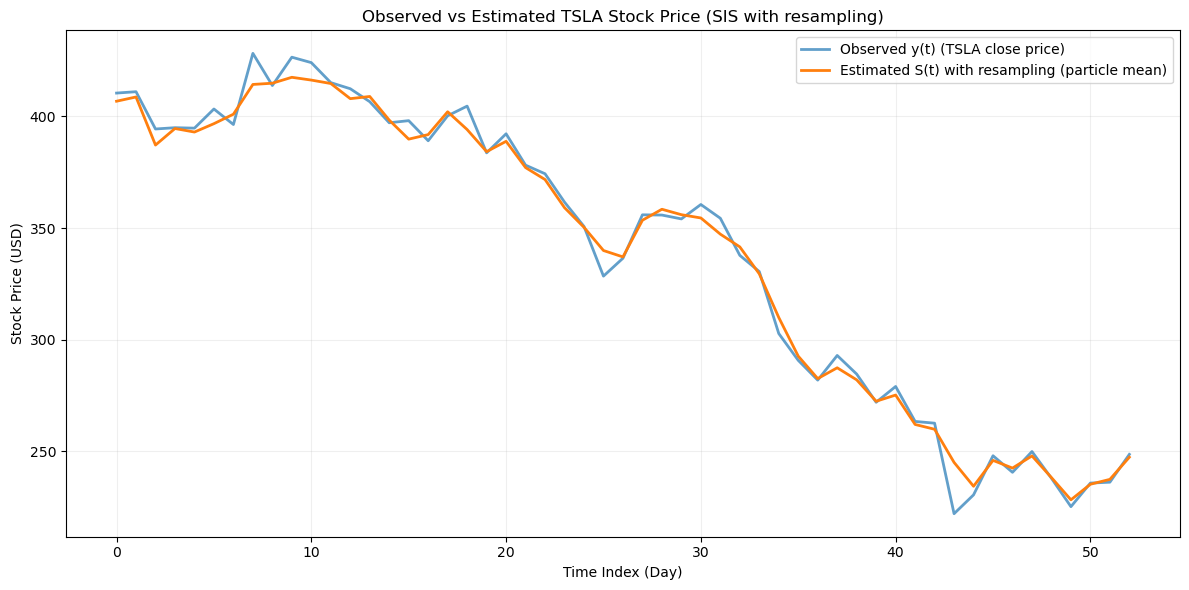

In [16]:
particles, weights, pred_price = sequential_importance_sampling(stock_prices, N, mu, sigma, tau, resampling=True)

# your code here
# Plot particles with resampling for visualization
T = particles.shape[1]
weights_t_res = np.ones(N) / N
S_est_res = np.zeros(T)

for t in range(T):
    log_obs = np.log(stock_prices[t])

    # Log-likelihood for current time for each particle (up to constant)
    log_likelihood_t = -0.5 * (log_obs - particles[:, t])**2 / tau**2

    # Update weights in log-space for numerical stability
    log_weights_t = np.log(weights_t_res + 1e-300) + log_likelihood_t
    log_weights_t -= np.max(log_weights_t)
    weights_t_res = np.exp(log_weights_t)
    weights_t_res /= np.sum(weights_t_res)

    # Posterior-weighted mean of S(t) = E[exp(x_t) | y(1:t)]
    S_est_res[t] = np.sum(weights_t_res * np.exp(particles[:, t]))

# Plot observed prices and estimated S(t) with resampling
plt.figure(figsize=(12, 6))
plt.plot(stock_prices, label='Observed y(t) (TSLA close price)', lw=2, alpha=0.7)
plt.plot(S_est_res, label='Estimated S(t) with resampling (particle mean)', lw=2)
plt.xlabel('Time Index (Day)')
plt.ylabel('Stock Price (USD)')
plt.title('Observed vs Estimated TSLA Stock Price (SIS with resampling)')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

**You do not need the following for the homework but** below I am also providing a function that plots the posterior approximation from SIS for the stock price at time t.

In [17]:
from scipy.stats import gaussian_kde

# Plot the approximated posterior
def plot_posterior(particles, weights, stock_prices, t, ticker):
    # Extract particles and weights at time t
    x_t = particles[:, t]  # Log-prices at time t
    w_t = weights          # Corresponding weights
    y_t = stock_prices[t]  # Observed price at time t

    # Weighted mean of the posterior
    weighted_mean = np.sum(w_t * x_t)
    price_mean = np.exp(weighted_mean)

    # Option 1: Histogram with weights
    plt.figure(figsize=(10, 6))
    plt.hist(x_t, bins=50, weights=w_t, density=True, alpha=0.6, color='skyblue', label='Posterior (Histogram)')

    # Option 2: Kernel Density Estimate (KDE) for smoother curve
    kde = gaussian_kde(x_t, weights=w_t)
    x_grid = np.linspace(min(x_t), max(x_t), 100)
    posterior_kde = kde(x_grid)
    plt.plot(x_grid, posterior_kde, 'r-', lw=2, label='Posterior (KDE)')

    # Plot observed log-price and weighted mean
    plt.axvline(np.log(y_t), color='green', linestyle='--', label=f'Observed log(y_t) = {np.log(y_t):.3f}')
    plt.axvline(weighted_mean, color='blue', linestyle='--', label=f'Weighted Mean = {weighted_mean:.3f}')

    plt.title(f'{ticker} Posterior p(x_{t} | y_1:{t}) on Day {t+1} (Log-Price)')
    plt.xlabel('Log-Price (x_t)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print some statistics
    print(f"Observed Price (y_{t}): ${y_t:.2f}")
    print(f"Weighted Particle Mean Price (e^x_t): ${price_mean:.2f}")

In [18]:
t = len(stock_prices)-1
plot_posterior(particles, weights, stock_prices, t, ticker)

NameError: name 'ticker' is not defined

**Question 3: Comparing Variational Inference and MCMC**

Variational Inference (VI) and Markov Chain Monte Carlo (MCMC) are two approaches for approximating Bayesian posteriors. MCMC generates samples from the exact posterior but can be slow, while VI finds a tractable approximation to the posterior and is often faster but less accurate. In this assignment, you will compare these methods using a Bayesian linear regression model where we estimate the posterior over regression coefficients.

For this part you will use data on movies that includes information about the movie’s: (a) budget, (b) revenue, (c) runtime, and, (f) IMBD rating. You will build a Bayesian model for the movie’s IMDB rating based on its runtime and the ratio of revenue over budget.

In [19]:
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt

#LOAD and CLEAN the data
df = pd.read_csv("tmdb_5000_movies.csv")

#keep only the movies with at least 150 votes
df = df[df['vote_count']>=150].reset_index(drop=True)

#keep only the movies with non-zero revenue and budget
df = df[(df['revenue']!=0) & (df['budget']!=0)].reset_index(drop=True)

df['rev_budget_ratio'] = df['revenue']/df['budget']


# Convert to numpy arrays
y = df['vote_average'].values
x1 = df['rev_budget_ratio'].values
x2 = df['runtime'].values

You will first train the model using MCMC and estimate the run time to sample from the full posterior. The code for this specification is provided to you below.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


MCMC Sampling Time: 63.89 seconds


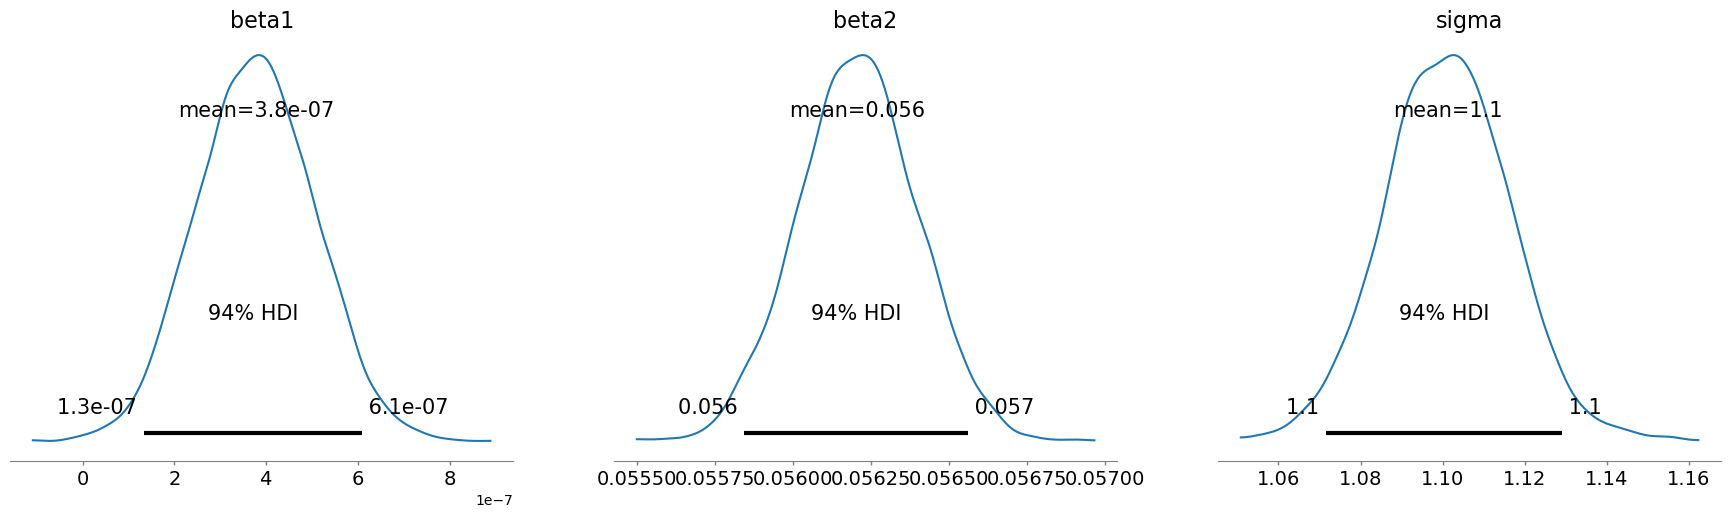

In [20]:
import time

# Bayesian Hierarchical Model
with pm.Model() as model:
    # Slope coefficients
    beta1 = pm.Normal("beta1", mu=0, sigma=10)  # Revenue/Budget
    beta2 = pm.Normal("beta2", mu=0, sigma=10)  # Runtime

    # model/y variance
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected rating
    mu = beta1 * x1 + beta2 * x2

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)


    # Start timing
    start_time = time.time()
    # Sample using MCMC
    trace = pm.sample(2000, return_inferencedata=True, tune=1000)
    # End timing
    end_time = time.time()

execution_time = end_time - start_time  # Calculate total time taken

mean_mcmc_b2 = trace.posterior['beta2'].values.flatten().mean() # the posterior mean for beta2

# Print time taken
print(f"MCMC Sampling Time: {execution_time:.2f} seconds")

# Plot posteriors
pm.plot_posterior(trace)
plt.show()

Next will implement `vi_model(iterations = 50000, n_samples = 2000)`, a function that will learn the same model but using variational inference, with parameters provided as arguments. The function will return the run time, as well as the mean of the posteriors for the 2 coefficients (`beta1` and `beta2`) of the model. 

In [26]:
# now let's apply VI

import time

def vi_model(iterations = 50000, n_samples = 2000):
#your code here
    with pm.Model() as vi_Model:
        #Priors (same as MCMC model)
        beta1 = pm.Normal("beta1", mu=0, sigma=10) # revenue budget
        beta2 = pm.Normal("beta2", mu=0, sigma=10) # Runtime
        sigma = pm.HalfNormal("sigma", sigma=1)
        
        # Linear predictor
        mu = beta1 * x1 + beta2 * x2
        
        # Likelihood
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        
        # start timing
        start_time = time.time()
        
        # Fit variational approximation
        approx = pm.fit(n=iterations, method="fullrank_advi")
        
        # sample from the variational posterior
        idata_vi = approx.sample(draws=n_samples)
        
        end_time = time.time()

    execution_time_vi = end_time - start_time

    # Posterior means for beta1 and beta2 from VI samples
    mean_vi_b1 = idata_vi.posterior["beta1"].values.flatten().mean()
    mean_vi_b2 = idata_vi.posterior["beta2"].values.flatten().mean()
    return execution_time_vi, mean_vi_b1, mean_vi_b2

You should compute the run time for 5 different numbers of iterations (5000, 10000, 25000, 50000, 100000) using fullrank_advi (`method="fullrank_advi"`), and plot the results together with the run time for the MCMC (the latter can be a horizontal line on the graph). (**Q5**).

Running VI with 5000 iteransions..


Finished [100%]: Average Loss = 3.4841e+13


Running VI with 10000 iteransions..


Finished [100%]: Average Loss = 8.6928e+11


Running VI with 25000 iteransions..


Finished [100%]: Average Loss = 7.8882e+06


Running VI with 50000 iteransions..


Finished [100%]: Average Loss = 15,132


Running VI with 100000 iteransions..


Finished [100%]: Average Loss = 13,254


VI run times (seconds): [2.9934396743774414, 4.834923505783081, 8.300760746002197, 15.702372550964355, 29.27507472038269]
VI posterior means beta1: [-0.009598180613280455, 0.014732973371549631, 0.0006052195871037176, 0.0003515228830836089, 7.996428783185924e-05]
VI posterior means beta2: [-0.022153723649864114, -0.06757061126107453, 0.14812937251346975, 0.057475852467092484, 0.05706990896658446]


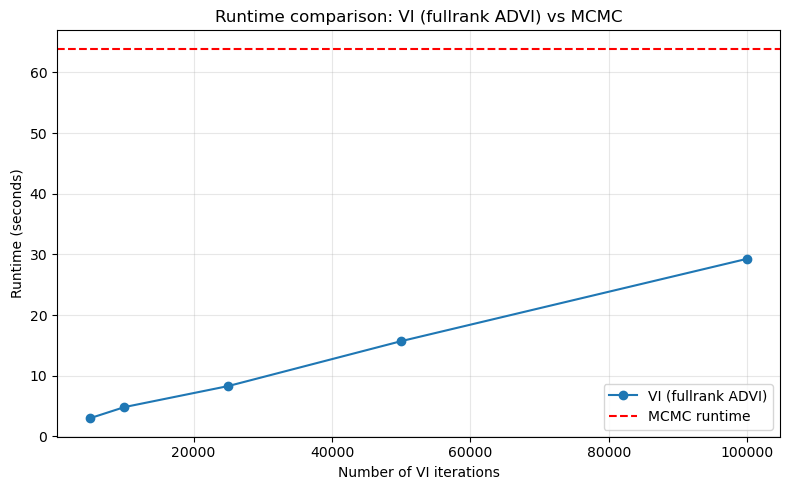

In [29]:
times_vi = []
means_vi_b1 = []
means_vi_b2 = []

iter_list = [5000, 10000, 25000, 50000, 100000]

for iters in iter_list:
    print(f"Running VI with {iters} iterations...")
    t_vi, m_b1, m_b2 = vi_model(iterations=iters, n_samples=2000)
    times_vi.append(t_vi)
    means_vi_b1.append(m_b1)
    means_vi_b2.append(m_b2)
print("VI run times (seconds):", times_vi)
print("VI posterior means beta1:", means_vi_b1)
print("VI posterior means beta2:", means_vi_b2)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(iter_list, times_vi, marker='o', label='VI (fullrank ADVI)')
plt.axhline(execution_time, color='red', linestyle='--', label='MCMC runtime')

plt.xlabel('Number of VI iterations')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime comparison: VI (fullrank ADVI) vs MCMC')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Using the same function, plot the difference between the posterior mean for  beta2 using the MCMC (full posterior) and its approximation for different numbers of iterations. What do you observe? (**Q6**).

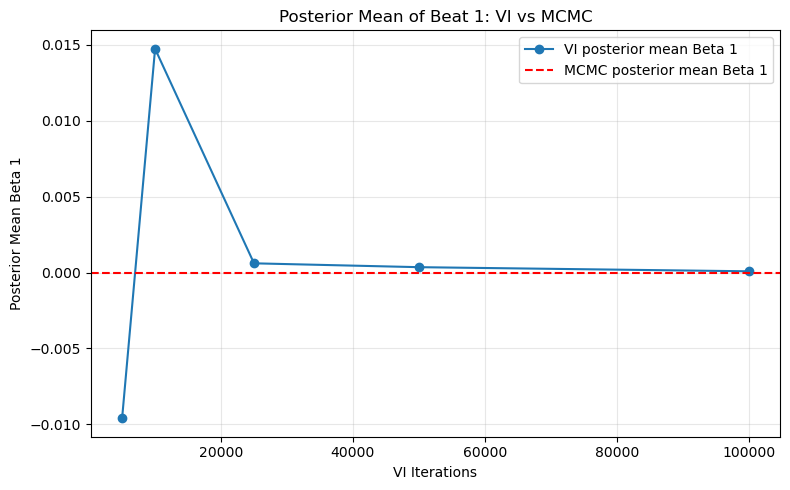

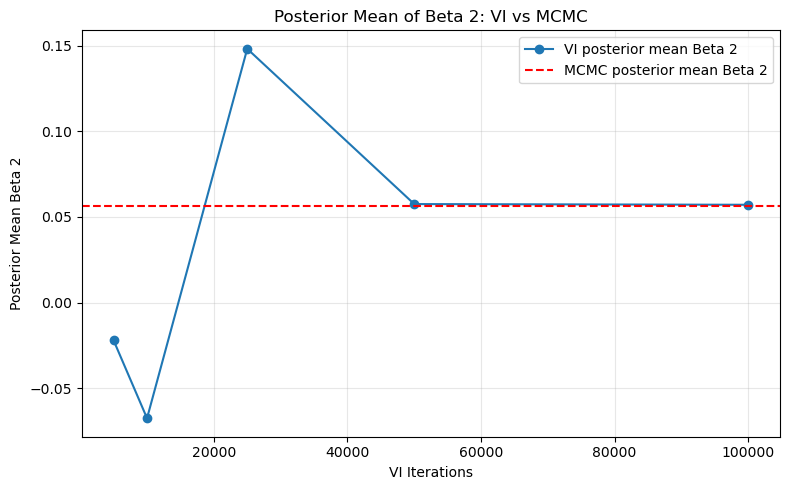

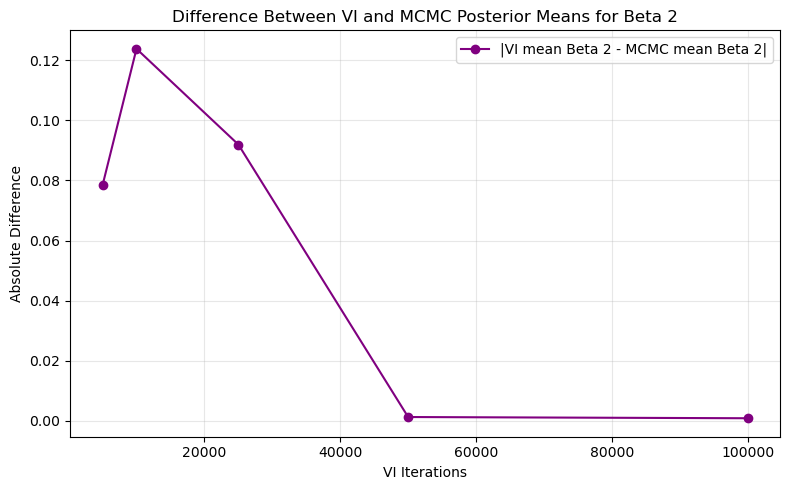

In [33]:
# your code here
# make 2 plots for means_vi_b1 and means_vi_b2 for x in [500, 1000, 25000, 50000, 100000] and horizontal lines at mean_mcmc_b1 and mean_mcmc_b2 respectively
# plot the results

vi_b1 = means_vi_b1
vi_b2 = means_vi_b2
mean_mcmc_b1 = trace.posterior['beta1'].values.flatten().mean()

diff_b2 = [abs(m-mean_mcmc_b2) for m in vi_b2]

plt.figure(figsize=(8,5))
plt.plot(iter_list, vi_b1, marker='o', label='VI posterior mean Beta 1')
plt.axhline(mean_mcmc_b1, color='red', linestyle='--', label='MCMC posterior mean Beta 1')
plt.xlabel('VI Iterations')
plt.ylabel('Posterior Mean Beta 1')
plt.title('Posterior Mean of Beat 1: VI vs MCMC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(iter_list, vi_b2, marker='o', label='VI posterior mean Beta 2')
plt.axhline(mean_mcmc_b2, color='red', linestyle='--', label='MCMC posterior mean Beta 2')
plt.xlabel('VI Iterations')
plt.ylabel('Posterior Mean Beta 2')
plt.title('Posterior Mean of Beta 2: VI vs MCMC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(iter_list, diff_b2, marker='o', color='purple', label='|VI mean Beta 2 - MCMC mean Beta 2|')
plt.xlabel('VI Iterations')
plt.ylabel('Absolute Difference')
plt.title('Difference Between VI and MCMC Posterior Means for Beta 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()